# **CIRRHOSIS**

## **Data Understanding**

### **Pengumpulan Data**

In [5]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

# Baca file CSV (ganti dengan nama file yang kamu upload)
df = pd.read_csv(next(iter(uploaded)))  # Ini otomatis ambil file pertama yang diupload


Saving cirrhosis.csv to cirrhosis.csv


In [4]:
import os

# Hapus file
os.remove('cirrhosis.csv')

print("File berhasil dihapus.")


File berhasil dihapus.


### **Menampilkan Data**

In [6]:
import pandas as pd
from IPython.display import display, HTML

# Ganti 'cirrhosis.csv' sesuai nama file hasil upload
data = pd.read_csv("cirrhosis.csv")

# Menampilkan
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

html_table = data.to_html(classes='table table-striped', border=0)
display(HTML(f"""
<div style="height: 500px; overflow-y: scroll; border:1px solid #ddd; padding:10px">
{html_table}
</div>
"""))

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
7,8,2466,D,Placebo,19379,F,N,N,N,N,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0
8,9,2400,D,D-penicillamine,15526,F,N,N,Y,N,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0
9,10,51,D,Placebo,25772,F,Y,N,Y,Y,12.6,200.0,2.74,140.0,918.0,147.25,143.0,302.0,11.5,4.0


### **Profiling Data**

#### Variabel Numerik

In [9]:
#Menghapus tampilan id
data = data.drop(columns=["ID"])

# Ambil kolom numerik saja
numeric_data = data.select_dtypes(include='number')

# Hitung statistik deskriptif
summary = pd.DataFrame({
    'mean': numeric_data.mean(),
    'median': numeric_data.median(),
    'count': numeric_data.count(),
    'std': numeric_data.std(),
    'min': numeric_data.min(),
    'max': numeric_data.max()
}).round(6)

# Tampilkan dengan HTML
html_table = summary.to_html(classes='table table-dark table-striped text-center', border=0)

display(HTML(f"""
<div style="max-height: 500px; overflow-y: auto; border:1px solid #ddd; padding:10px; border-radius:6px">
{html_table}
</div>
"""))


,mean,median,count,std,min,max
N_Days,1917.782297,1730.00,418,1104.672992,41.00,4795.00
Age,18533.351675,18628.00,418,3815.845055,9598.00,28650.00
Bilirubin,3.220813,1.40,418,4.407506,0.30,28.00
Cholesterol,369.510563,309.50,284,231.944545,120.00,1775.00
Albumin,3.497440,3.53,418,0.424972,1.96,4.64
Copper,97.648387,73.00,310,85.613920,4.00,588.00
Alk_Phos,1982.655769,1259.00,312,2140.388824,289.00,13862.40
SGOT,122.556346,114.70,312,56.699525,26.35,457.25
Tryglicerides,124.702128,108.00,282,65.148639,33.00,598.00
Platelets,257.024570,251.00,407,98.325585,62.00,721.00


#### Variabel Kategorikal

In [15]:
# Ambil kolom kategorikal (non-numeric)
categorical_data = data.select_dtypes(include='object')

# Buat summary kategorikal
cat_summary = pd.DataFrame({
    'non_null_count': categorical_data.count(),
    'missing_count': categorical_data.isnull().sum(),
    'unique_count': categorical_data.nunique(),
    'sample_unique_values': categorical_data.apply(
        lambda x: ', '.join(x.dropna().astype(str).unique()[:5]) + ('...' if x.nunique() > 5 else '')
    )
})

# Tampilkan sebagai HTML
cat_html_table = cat_summary.to_html(classes='table table-bordered table-hover text-start', border=0)

display(HTML(f"""
<div style="max-height: 500px; overflow-y: auto; border:1px solid #ddd; padding:10px; border-radius:6px">
{cat_html_table}
</div>
"""))


,non_null_count,missing_count,unique_count,sample_unique_values
Status,418,0,3,"D, C, CL"
Drug,312,106,2,"D-penicillamine, Placebo"
Sex,418,0,2,"F, M"
Ascites,312,106,2,"Y, N"
Hepatomegaly,312,106,2,"Y, N"
Spiders,312,106,2,"Y, N"
Edema,418,0,3,"Y, N, S"


#### Visualisasi

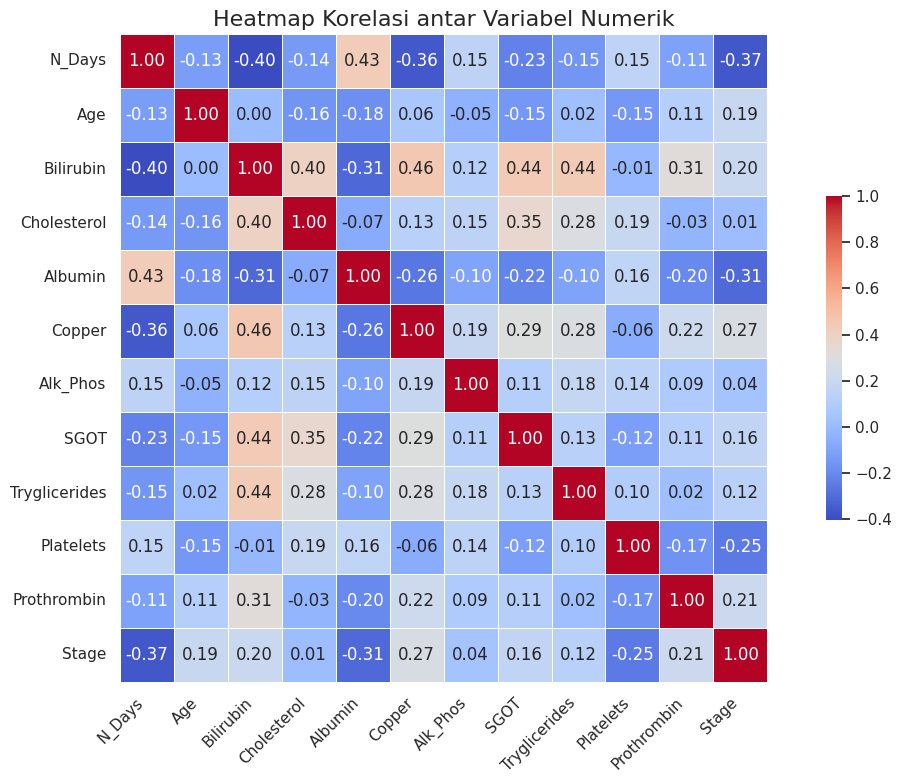

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan hanya menggunakan kolom numerik
numeric_data = data.select_dtypes(include='number')

# Hitung korelasi
correlation_matrix = numeric_data.corr()

# Set ukuran plot
plt.figure(figsize=(12, 8))

# Buat heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': .5})

# Tambahkan judul
plt.title('Heatmap Korelasi antar Variabel Numerik', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Tampilkan
plt.show()


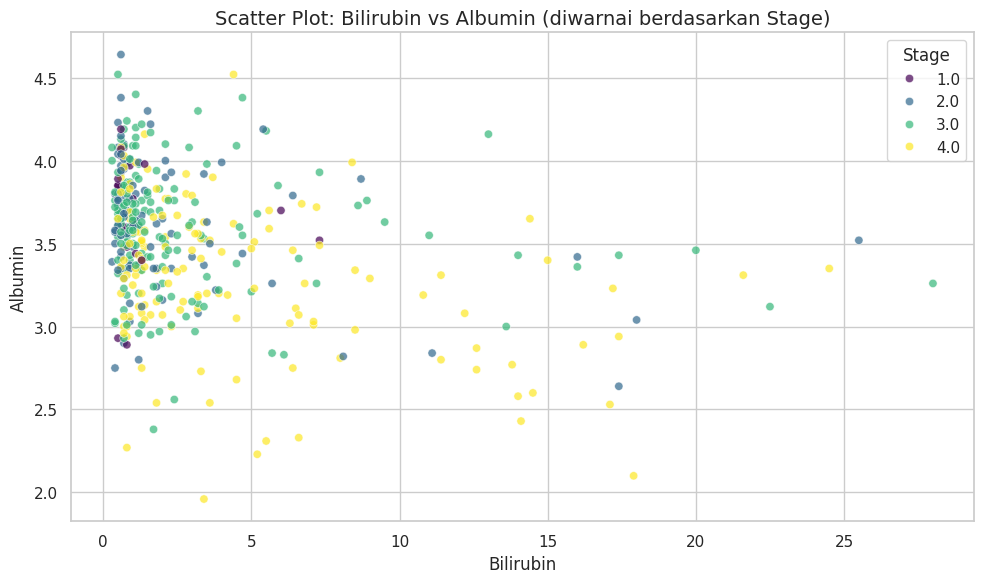

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ukuran plot
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(data=data, x='Bilirubin', y='Albumin', hue='Stage', palette='viridis', alpha=0.7)

# Tambahkan judul dan label
plt.title('Scatter Plot: Bilirubin vs Albumin (diwarnai berdasarkan Stage)', fontsize=14)
plt.xlabel('Bilirubin')
plt.ylabel('Albumin')
plt.legend(title='Stage')
plt.grid(True)
plt.tight_layout()

# Tampilkan plot
plt.show()


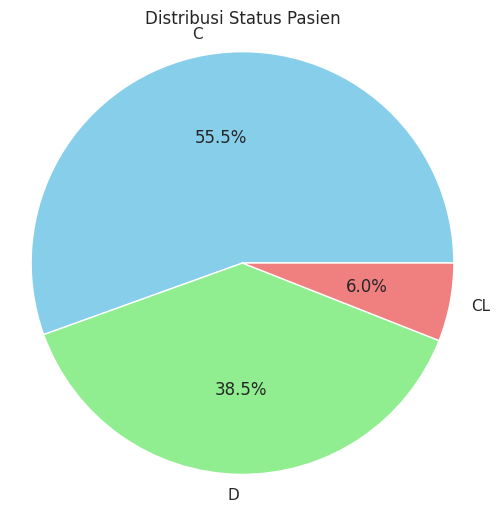

In [18]:
import matplotlib.pyplot as plt

# Hitung proporsi tiap kategori di kolom 'Status'
status_counts = data['Status'].value_counts()

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribusi Status Pasien')
plt.axis('equal')  # Biar bentuknya bulat sempurna
plt.show()


### **Identifikasi Masalah**

#### Mengecek Missing Value

In [21]:
from IPython.display import display, HTML

# Hitung missing value
missing = data.isnull().sum()

# Konversi ke DataFrame
missing_df = pd.DataFrame(missing, columns=['Missing Values'])

# Tampilkan sebagai HTML
html_table = missing_df.to_html(classes='table table-bordered table-striped text-center', border=0)

display(HTML(f"""
<div style="max-height: 400px; overflow-y: auto; border:1px solid #ccc; padding:10px; border-radius:6px">
<h4>Missing Values per Column</h4>
{html_table}
</div>
"""))


,Missing Values
N_Days,0
Status,0
Drug,106
Age,0
Sex,0
Ascites,106
Hepatomegaly,106
Spiders,106
Edema,0
Bilirubin,0


#### Mengecek Duplikasi

In [25]:
# Cek jumlah data duplikat
duplicate_count = data.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicate_count}")

Jumlah baris duplikat: 0


#### Mengecek Outlier

In [29]:
def indeks_outlier_iqr(series, iqr_multiplier=1.5):
    """
    Detect outliers using IQR method. Returns the indices and values of the outliers.

    Parameters:
    - series: The numeric data series (Pandas Series).
    - iqr_multiplier: The multiplier for IQR to define the bounds (default is 1.5).

    Returns:
    - outlier_indices: Indices of the outliers.
    - outlier_values: Values of the outliers.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]

    return outliers.index, outliers

outlier_indices_per_feature = {}
outlier_values_per_feature = {}

# Detect outliers for each numeric column
for col in numeric_cols:
    outlier_idx, outlier_vals = indeks_outlier_iqr(data[col].dropna(), iqr_multiplier=1.5)
    outlier_indices_per_feature[col] = outlier_idx.tolist()
    outlier_values_per_feature[col] = outlier_vals.tolist()

# Display the results
for fitur, indices in outlier_indices_per_feature.items():
    print(f"\nFitur: {fitur}")
    print(f"Jumlah outlier: {len(indices)}")
    print(f"ID: {indices}")
    print(f"Outlier values: {outlier_values_per_feature[fitur]}")



Fitur: N_Days
Jumlah outlier: 0
ID: []
Outlier values: []

Fitur: Age
Jumlah outlier: 0
ID: []
Outlier values: []

Fitur: Bilirubin
Jumlah outlier: 46
ID: [0, 9, 17, 22, 26, 27, 62, 68, 73, 74, 75, 80, 94, 127, 129, 137, 143, 155, 163, 183, 186, 190, 192, 216, 222, 234, 242, 280, 287, 291, 292, 331, 337, 340, 342, 343, 350, 361, 367, 369, 370, 375, 381, 386, 397, 398]
Outlier values: [14.5, 12.6, 11.4, 17.4, 21.6, 17.2, 22.5, 20.0, 8.4, 17.1, 12.2, 14.4, 17.4, 16.2, 17.4, 7.3, 28.0, 25.5, 8.5, 11.0, 14.0, 24.5, 10.8, 11.4, 14.1, 13.0, 8.0, 17.9, 8.7, 8.6, 8.5, 12.6, 16.0, 9.0, 11.1, 8.9, 15.0, 18.0, 13.8, 16.0, 7.3, 9.5, 14.0, 13.6, 7.3, 8.1]

Fitur: Cholesterol
Jumlah outlier: 20
ID: [25, 62, 68, 74, 85, 89, 116, 118, 129, 147, 165, 183, 186, 190, 192, 214, 234, 246, 293, 294]
Outlier values: [1128.0, 932.0, 652.0, 674.0, 1600.0, 660.0, 950.0, 636.0, 1775.0, 1015.0, 1480.0, 674.0, 808.0, 1092.0, 932.0, 1276.0, 1336.0, 1712.0, 1000.0, 646.0]

Fitur: Albumin
Jumlah outlier: 9
ID: [13, 

## **Preprocessing**

### Data Outlier

In [36]:
import pandas as pd
from IPython.display import display, HTML

# Ganti 'cirrhosis.csv' sesuai nama file hasil upload
data = pd.read_csv("cirrhosis.csv")

# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(series, iqr_multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

# Mengidentifikasi outlier untuk setiap kolom numerik
outlier_flags = {}
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    outlier_flags[col] = detect_outliers_iqr(data[col])

# Menambahkan kolom baru untuk menandai apakah data adalah outlier (True) atau bukan (False)
for col in numeric_cols:
    # Membuat kolom baru yang menandai apakah nilai adalah outlier (True) atau normal (False)
    outlier_column_name = f"{col}_outlier"
    data[outlier_column_name] = outlier_flags[col]

# Menampilkan data dengan kolom outlier baru
html_table = data.to_html(classes='table table-striped', escape=False, border=0)

# Menampilkan tabel dengan kolom outlier
display(HTML(f"""
<div style="height: 500px; overflow-y: scroll; border:1px solid #ddd; padding:10px">
{html_table}
</div>
"""))


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,ID_outlier,N_Days_outlier,Age_outlier,Bilirubin_outlier,Cholesterol_outlier,Albumin_outlier,Copper_outlier,Alk_Phos_outlier,SGOT_outlier,Tryglicerides_outlier,Platelets_outlier,Prothrombin_outlier,Stage_outlier
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,False,False,False,True,False,False,False,False,False,False,False,False,False
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,False,False,False,False,False,False,False,True,False,False,False,False,False
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,False,False,False,False,False,False,False,True,False,False,False,False,False
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False
7,8,2466,D,Placebo,19379,F,N,N,N,N,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0,False,False,False,False,False,False,False,True,False,False,False,False,False
8,9,2400,D,D-penicillamine,15526,F,N,N,Y,N,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0,False,False,False,False,False,False,False,False,False,False,False,False,False
9,10,51,D,Placebo,25772,F,Y,N,Y,Y,12.6,200.0,2.74,140.0,918.0,147.25,143.0,302.0,11.5,4.0,False,False,False,True,False,False,False,False,False,False,False,False,False


### Menghapus Outlier

In [37]:
import pandas as pd
from IPython.display import display, HTML

# Ganti 'cirrhosis.csv' sesuai nama file hasil upload
data = pd.read_csv("cirrhosis.csv")

# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(series, iqr_multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

# Mengidentifikasi outlier untuk setiap kolom numerik
outlier_flags = {}
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    outlier_flags[col] = detect_outliers_iqr(data[col])

# Membuat mask untuk mendeteksi baris yang mengandung outliers di semua kolom
outlier_mask = pd.DataFrame(False, index=data.index, columns=numeric_cols)

for col in numeric_cols:
    outlier_mask[col] = outlier_flags[col]

# Menghitung jumlah baris yang mengandung outliers di setiap kolom
outlier_count = outlier_mask.sum().sum()

# Menghapus baris yang mengandung outliers (jika ada outlier di salah satu kolom)
data_no_outliers = data[~outlier_mask.any(axis=1)]

# Menampilkan jumlah baris yang dihapus
print(f"Jumlah baris yang dihapus (terdeteksi sebagai outlier): {outlier_count}")

# Menampilkan data setelah penghapusan outliers
html_table = data_no_outliers.to_html(classes='table table-striped', escape=False, border=0)

# Menampilkan tabel setelah penghapusan outliers
display(HTML(f"""
<div style="height: 500px; overflow-y: scroll; border:1px solid #ddd; padding:10px">
{html_table}
</div>
"""))


Jumlah baris yang dihapus (terdeteksi sebagai outlier): 168


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
8,9,2400,D,D-penicillamine,15526,F,N,N,Y,N,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0
10,11,3762,D,Placebo,19619,F,N,Y,Y,N,1.4,259.0,4.16,46.0,1104.0,79.05,79.0,258.0,12.0,4.0
12,13,3577,C,Placebo,16688,F,N,N,N,N,0.7,281.0,3.85,40.0,1181.0,88.35,130.0,244.0,10.6,3.0
15,16,3672,C,Placebo,14772,F,N,N,N,N,0.7,204.0,3.66,28.0,685.0,72.85,58.0,198.0,10.8,3.0
16,17,769,D,Placebo,19060,F,N,Y,N,N,2.7,274.0,3.15,159.0,1533.0,117.80,128.0,224.0,10.5,4.0
18,19,4232,C,D-penicillamine,18102,F,N,Y,N,S,0.7,235.0,3.56,39.0,1881.0,93.00,123.0,209.0,11.0,3.0


## **Model Klasifikasi**

## **Evaluasi**